# Imports and Gpu device Setup

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
# Device setup for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train and Test Dataset

In [3]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=transforms.ToTensor(),
    target_transform=None,
    download=True
)

In [4]:
test_data = datasets.MNIST(
    root="data",
    train=False,
    transform=transforms.ToTensor(),
    target_transform=None,
    download=True
)

# Custom dataset Class for triplets

In [5]:
# Custom dataset for triplets, as you asked me to implement this in my code
class MnistTripletDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.data = mnist_dataset.data
        self.targets = mnist_dataset.targets

    def __len__(self):
        return len(self.mnist_dataset) // 3

    def __getitem__(self, idx):
        idx1, idx2, idx3 = idx * 3, idx * 3 + 1, idx * 3 + 2
        img1, label1 = self.mnist_dataset[idx1]
        img2, label2 = self.mnist_dataset[idx2]
        img3, label3 = self.mnist_dataset[idx3]
        images = torch.stack([img1, img2, img3])
        labels = torch.tensor([label1, label2, label3], dtype=torch.long)
        return images, labels

# Train and Test DataLoder

In [6]:
# DataLoaders as it was required in the Notion Link you shared
train_dataset = MnistTripletDataset(train_data)
test_dataset = MnistTripletDataset(test_data)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Model Architecture -> Encoder-Decoder( CNN + LSTM )

In [7]:
# Model architecture: Encoder-Decoder with CNN as the encoder
class EncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout
            nn.MaxPool2d(kernel_size=2, stride=1)
        )

        # Flatten and process sequence with LSTM

        feature_size = 10 * 30 * 30  

        # After CNN encoding, each image becomes a 10×30×30 feature map (channels × height × width)
        # We flatten this into a single vector of size 9000 to pass into the LSTM as input_size


        # batch_first=True ensures input and output tensors are of shape (batch_size, seq_len, input_size)
        self.lstm = nn.LSTM(input_size=feature_size, hidden_size=128, num_layers=1, batch_first=True)

        # Decoder is a fully connected layer that maps the final LSTM output (128 features)
        # to 30 output units (3 digits × 10 possible classes each)
        self.decoder = nn.Linear(128, 10 * 3)


    def forward(self, x):
        batch_size = x.size(0)         # Extract batch size (32 samples in one batch)
        seq_len = x.size(1)            # Extract sequence length (should be 3 images per sample)

        x = x.view(batch_size * seq_len, 1, 28, 28)  # Flatten the sequence into a single batch for CNN
                                                    # Shape becomes (batch_size * 3, 1, 28, 28)

        x = self.encoder(x)           # Pass each image through the CNN encoder
                                    # Output shape: (batch_size * 3, 10, 30, 30)

        x = x.view(batch_size, seq_len, -1)  # Reshape CNN output back into sequences
                                            # Each image is now a 9000-dim vector → shape: (batch_size, 3, 9000)

        x, _ = self.lstm(x)           # Pass sequence of 3 vectors (per sample) through the LSTM
                                    # x = all LSTM outputs → shape (batch_size, 3, 128) and i used _ because lstm outputs hidden and cell states as tuple

        x = self.decoder(x[:, -1, :])  # Use only the output of the last time step (x[:, -1, :])

        return x.view(batch_size, 3, 10)  # Reshape the 30 output values into (3 digits × 10 classes)

# Loss Function and Optimizer

In [8]:
# Initialize model, loss, and optimizer
model = EncoderDecoder().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Place the model weights named as **"best_model.pth"** in same directory for model loading.

**Uncomment** the below code for Loading the model.

In [ ]:
# model.load_state_dict(torch.load('best_model.pth'))
# model.eval()

# Training and Validation Loop

If Model is loaded successfully then **do not run** the Training Loop Given Below.

In [9]:
num_epochs = 15
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')  # positive infinity for early stopping
patience = 1  # number of epochs to wait for improvement
counter = 0  # counter for epochs without improvement

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_seq_train = 0
    total_seq_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs.view(-1, 10), labels.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.argmax(dim=2)
        correct_seq_train += (preds == labels).all(dim=1).sum().item()
        total_seq_train += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_seq_accuracy = correct_seq_train / total_seq_train
    train_accuracies.append(train_seq_accuracy)

    # Evaluation
    model.eval()
    val_loss = 0.0
    correct_seq_val = 0
    total_seq_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs.view(-1, 10), labels.view(-1))
            val_loss += loss.item()
            preds = outputs.argmax(dim=2)
            correct_seq_val += (preds == labels).all(dim=1).sum().item()
            total_seq_val += labels.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_seq_accuracy = correct_seq_val / total_seq_val
    val_accuracies.append(val_seq_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss*100:.4f}%, Train Accuracy: {train_seq_accuracy*100:.4f}%, Val Loss: {avg_val_loss*100:.4f}%, Val Accuracy: {val_seq_accuracy*100:.4f}%")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"\n\n\t\tEarly stopping triggered after epoch {epoch+1}\n")
            break

Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1, Train Loss: 71.2668%, Train Accuracy: 61.1600%, Val Loss: 16.5638%, Val Accuracy: 89.5590%


Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2, Train Loss: 11.9314%, Train Accuracy: 91.7550%, Val Loss: 10.0569%, Val Accuracy: 92.6793%


Epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3, Train Loss: 6.7273%, Train Accuracy: 95.1100%, Val Loss: 8.9229%, Val Accuracy: 92.9793%


Epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4, Train Loss: 4.3614%, Train Accuracy: 96.8200%, Val Loss: 7.3571%, Val Accuracy: 93.4293%


Epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5, Train Loss: 2.8460%, Train Accuracy: 98.0200%, Val Loss: 6.8018%, Val Accuracy: 93.7894%


Epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 6, Train Loss: 1.9884%, Train Accuracy: 98.7200%, Val Loss: 6.4576%, Val Accuracy: 94.3294%


Epoch 7:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 7, Train Loss: 1.4051%, Train Accuracy: 99.1800%, Val Loss: 6.8502%, Val Accuracy: 93.7594%


		Early stopping triggered after epoch 7



# visualizing Predictions

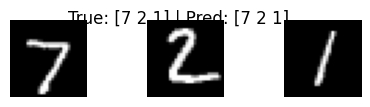

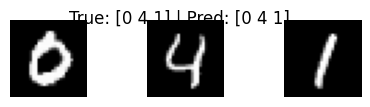

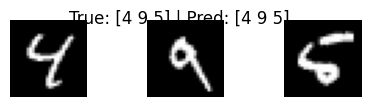

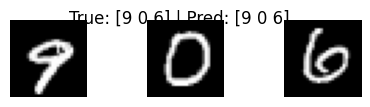

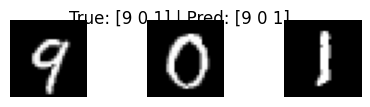

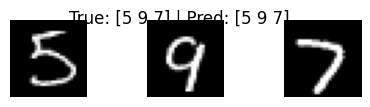

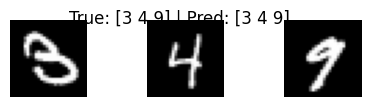

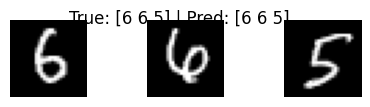

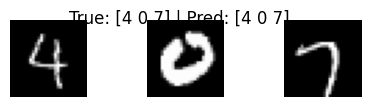

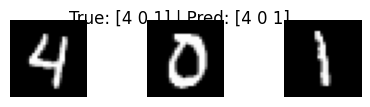

In [16]:
def visualize_predictions(model, loader, num_samples=10):
    model.eval()
    images, labels = next(iter(loader))  # Get one batch
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        preds = model(images).argmax(dim=2)

    for i in range(min(num_samples, images.size(0))):
        plt.figure(figsize=(5, 1))
        for j in range(3):  # Show 3 digits in the sequence
            plt.subplot(1, 3, j+1)
            plt.imshow(images[i, j].cpu().squeeze(), cmap='gray')
            plt.axis('off')
        true_seq = labels[i].cpu().numpy()
        pred_seq = preds[i].cpu().numpy()
        plt.suptitle(f"True: {true_seq} | Pred: {pred_seq}")
        plt.show()

visualize_predictions(model, test_loader)